# Boston_Housing - Regression Analysis

## Import TensorFlow & Keras

* TensorFlow Version 지정

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

tf.__version__

'1.15.0'

* GPU 설정 Off

In [0]:
tf.test.gpu_device_name()

''

* Keras Version 확인

In [0]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.5'

# I. Boston_Housing Data_Set Load & Review

> ## 1) Load Boston_Housing Data_Set

In [0]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


> ## 2) Data_Set Information

In [0]:
print(train_data.shape)
print(test_data.shape)

print(train_targets[:10])
print(test_targets[:10])

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


# II. Data Preprocessing

> ## 1) Standardization

 * train_data & test_data

In [0]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

> ## 2) Train & Validation Split

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_targets, 
                                                      test_size = 0.2, 
                                                      random_state = 2045) 

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((323, 13), (81, 13), (323,), (81,))

# III. Boston_Housing Keras Modeling

> ## 1) Model Define

In [0]:
from keras import models
from keras import layers

boston = models.Sequential(name = 'Regression')
boston.add(layers.Dense(64, activation = 'relu', input_shape = (13,)))
boston.add(layers.Dense(64, activation = 'relu'))
boston.add(layers.Dense(1))

In [0]:
boston.summary()

Model: "Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [0]:
boston.compile(loss = 'mse',
               optimizer = 'rmsprop',
               metrics = ['mae'])

> ## 3) Model Fit

 * 약 3분

In [0]:
Hist_boston = boston.fit(x_train, y_train,
                         epochs = 500,
                         batch_size = 1,
                         validation_data = (x_valid, y_valid))

> ## 4) Model Evaluate

In [0]:
test_mse_score, test_mae_score = boston.evaluate(test_data, test_targets)

print('MAE is :',test_mae_score)

102/102 [==============================] - 0s 134us/step
MAE is : 2.51510633206835


> ## 5) Visualization

* 전체 시각화

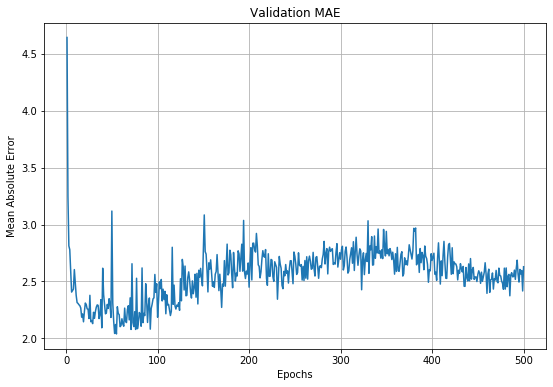

In [0]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_boston.history['val_mean_absolute_error']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_boston.history['val_mean_absolute_error'])
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

* 5번째 이후 MAE 확인

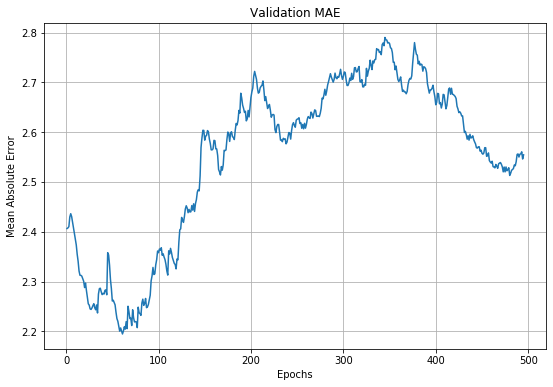

In [0]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

mae_history = Hist_boston.history['val_mean_absolute_error']

mae_history = smooth_curve(mae_history[5:])

plt.figure(figsize = (9, 6))
plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

> ## 6) Keras Session Clear

In [0]:
from keras import backend as K

K.clear_session()

# IV. Early Stopping

> ## 1) Model Define & Compile

In [0]:
from keras import models
from keras import layers

boston = models.Sequential(name = 'EarlyStopping')
boston.add(layers.Dense(64, activation = 'relu', input_shape = (13,)))
boston.add(layers.Dense(64, activation = 'relu'))
boston.add(layers.Dense(1))

boston.compile(loss = 'mse',
               optimizer = 'rmsprop',
               metrics = ['mae'])

> ## 2) EarlyStopping( )

* monitor : 모니터링 대상 성능
* mode : 모니터링 대상을 최소화(min) 또는 최대화(max)
* patience : 성능이 개선되지 않는 epoch 횟수

In [0]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_mean_absolute_error', 
                   mode = 'min', 
                   patience = 15, 
                   verbose = 1)

> ## 3) ModelCheckpoint( )

* 'best_boston.h5' : 최적모델이 저장될 경로
* save_best_only : 최적모델만 저장할지 지정

In [0]:
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_boston.h5', 
                     monitor = 'val_mean_absolute_error', 
                     mode = 'min', 
                     save_best_only = True,
                     verbose = 1)

> ## 4) Model Fit with callbacks

* callbacks : Earlystopping( ) 과 ModelCheckpoint( ) 객체 지정

In [0]:
Hist_boston = boston.fit(x_train, y_train,
                         epochs = 500,
                         batch_size = 1,
                         validation_data = (x_valid, y_valid),
                         callbacks = [es, mc],
                         verbose = 1)

Train on 323 samples, validate on 81 samples
Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 188.7148 - mean_absolute_error: 10.1044 - val_loss: 52.0504 - val_mean_absolute_error: 4.2795

Epoch 00001: val_mean_absolute_error improved from inf to 4.27952, saving model to best_boston.h5
Epoch 2/500
323/323 [==============================] - 0s 1ms/step - loss: 28.0650 - mean_absolute_error: 3.5556 - val_loss: 30.1068 - val_mean_absolute_error: 2.9930

Epoch 00002: val_mean_absolute_error improved from 4.27952 to 2.99305, saving model to best_boston.h5
Epoch 3/500
323/323 [==============================] - 0s 1ms/step - loss: 20.3560 - mean_absolute_error: 2.9978 - val_loss: 25.4594 - val_mean_absolute_error: 2.6026

Epoch 00003: val_mean_absolute_error improved from 2.99305 to 2.60256, saving model to best_boston.h5
Epoch 4/500
323/323 [==============================] - 0s 1ms/step - loss: 16.8398 - mean_absolute_error: 2.7024 - val_loss: 20.0321 - val_mean_abs

> ## 5) Best Model

In [0]:
!ls -l

total 68
-rw-r--r-- 1 root root 62464 Feb 20 12:51 best_boston.h5
drwxr-xr-x 1 root root  4096 Feb  5 18:37 sample_data


> ## 6) Model Evaluate

In [0]:
test_mse_score, test_mae_score = boston.evaluate(test_data, test_targets)

print('MAE is :',test_mae_score)

102/102 [==============================] - 0s 127us/step
MAE is : 2.650854886746874


# 
# 
# 
# The End
# 
# 
# 